In [1]:
from IPython.display import display

import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.style.use('default')


In [3]:
_palette = sns.color_palette("bright", n_colors=10 )
PALETTE = {
    "SDCI": _palette[1],
    "SDCI-GPU": _palette[1],
    "DCDI": _palette[0],
    "NOTEARS": _palette[2],
    "NOBEARS": _palette[4],
    "DCDFG": _palette[6],
    "DAGMA": _palette[9],
    "GIES": _palette[8],
    "sortnregress": _palette[7],
}

# Interventional benchmark

In [18]:
# SDCI and DCDI were ran on seeds 0,1,2,3,4
# DCD-FG and GIES only on seeds 0,1,2 (they have very poor SHD so not worth it to evaluate on more seeds)
# only include seeds 0,1,2 when comparing all methods
# sometimes DCDI crashed and so no SHD is reported

data.groupby(["Name", "d", "s"]).count()[["shd"]].reset_index().pivot_table(index="Name", columns=("d", "s"), values="shd")


d        20                      30                      40                  
s         2     4     6     8     2     4     6     8     2     4     6     8
Name                                                                         
DCDFG  15.0  15.0  15.0  15.0  15.0  15.0  15.0  15.0  15.0  15.0  15.0  15.0
DCDI   25.0  25.0  25.0  25.0  23.0  23.0  23.0  25.0  22.0  21.0  20.0  18.0
GIES   15.0  15.0  15.0  15.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
SDCI   25.0  25.0  25.0  25.0  25.0  25.0  25.0  25.0  25.0  25.0  25.0  25.0

In [12]:
data = pd.read_csv("./final_experiments/interventions-frac.csv")

data=data[data["State"] == "finished"]
data=data[data["seed"].isin([0,1,2,3,4])]


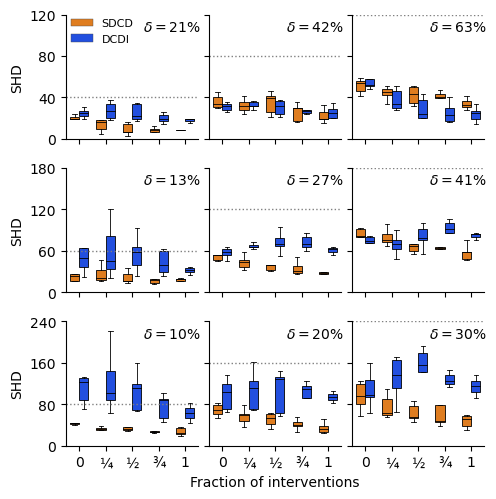

In [36]:
# plot
n_d = 3
n_s = 3
fig, axs = plt.subplots(n_d, n_s, figsize=(1.7 * n_s, 1.7 * n_d), sharex=True, sharey="row", dpi=100)


PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    "linewidth":0.6,
    "width": 0.7,
    "showfliers":False,
}

data = data[data["Name"].isin(["SDCI", "DCDI"])]
ds = [20, 30, 40]
ss = [2, 4, 6]

for i, d in enumerate(ds):
    n_edges = []
    for j, s in enumerate(ss):
        ax = axs[i, j]
        sns.boxplot(
            data=data[(data["d"] == d) & (data["s"] == s)],
            x="intervention_frac",
            y="shd",
            hue="Name",
            ax=ax,
            hue_order=["SDCI", "DCDI"],
            palette=PALETTE,
            **PROPS,
        )
        n_edge = d*s
        n_edges.append(n_edge)
        ax.axhline(n_edge, 0,1, c="gray", lw=1, ls=":")

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        #         ax.set_xlim(0,1)
        
        info = f"$\\delta={int(s*2 / (d-1)*100)}\\%$"
        ax.text(0.8, 0.9, info,
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax.transAxes
        )

#         ax.set_title(info)
        if i == n_d - 1:
            ax.set_xlabel("Intervention Fraction")
        if j == 0:
            ax.set_ylabel("SHD")
        else:
            ax.set_ylabel("")
        if i == 2:
            if j == 1:
                ax.set_xlabel("Fraction of interventions")
            else:
                ax.set_xlabel("")
                
            ax.set_xticklabels(["0", "¼", "½", "¾", "1"])
        else:
            ax.set_xlabel("")
#         ax.legend()

        if i == 0 and j == 0:
            legend = ax.legend(loc="upper left", fontsize=8,bbox_to_anchor=(-0.04,1.05) )
            legend.set_title(None)
            legend.set_frame_on(False)
            legend.get_texts()[0].set_text('SDCD')
        else:
            ax.get_legend().set_visible(False)
    
    ax.set_ylim(0, max(n_edges))
    ax.set_yticks([0] + n_edges)
    

fig.tight_layout(w_pad=0, )
plt.savefig("intervention.frac.svg", bbox_inches="tight", pad_inches=0, )


# DCDI data

In [41]:
sdcd = pd.read_csv("final_experiments/dcdi-data.csv")
sdcd["nodes_edges"] = sdcd["Name"].str.split("_").str[1:3].str.join("_")

In [42]:
dcdi_linear = pd.read_csv("dcdi_data/linear.csv", index_col=0)
dcdi_additive = pd.read_csv("dcdi_data/additive.csv", index_col=0)
dcdi_nn = pd.read_csv("dcdi_data/nn.csv", index_col=0)

In [43]:
# shd is not the last epoch: 0.1_dag_shd is

sdcd_results = sdcd.groupby(["dataset_name", "nodes_edges"])["0.1_dag_shd"].agg(["mean", "std"]).reset_index()
for name, df in [("linear", dcdi_linear), ('nnadd', dcdi_additive), ('nn', dcdi_nn)]:
    keep = ["DCDI-DSF", "DCDI-G"]
    df.drop(list(set(df.index) - set(keep)), inplace=True)
    tmp = sdcd_results[sdcd_results["dataset_name"].str.contains(name + "_")]
    tmp = tmp.sort_values("nodes_edges")[["mean", "std"]].values.reshape(-1).tolist()
    df.loc["SDCD"] = tmp
    df["average__shd_mean"] = df[[c for c in df.columns if "mean" in c]].mean(axis=1)
    df["average__shd_std"] = df[[c for c in df.columns if "std" in c]].pow(2).mean(axis=1).pow(0.5)
    

In [44]:
for df in [dcdi_linear, dcdi_additive, dcdi_nn]:
    
    for c in list(df.columns[::2]):
        dataset = "_".join(c.split("_")[:2])
        best_row = df.index[np.argmin(df[c].values)]
        df[dataset] = (
            "$"
            + df[dataset + "_shd_mean"].round(1).astype(str)
            + r"{\scriptstyle \pm"
            + df[dataset + "_shd_std"].round(1).astype(str)
            + r"}$"
        )
        df.loc[best_row, dataset] = r"$\mathbf{" + df.loc[best_row, dataset][1:-1] + r"}$"
        del df[dataset + "_shd_mean"]
        del df[dataset + "_shd_std"]
    df.columns = ["d=10, s=1", "d=10, s=4", "d=20, s=1", "d=20, s=4", "average"]

In [45]:
print(dcdi_linear.iloc[:, :4].to_latex())

\begin{tabular}{lllll}
\toprule
 & d=10, s=1 & d=10, s=4 & d=20, s=1 & d=20, s=4 \\
Method &  &  &  &  \\
\midrule
DCDI-G & $1.3{\scriptstyle \pm1.9}$ & $\mathbf{3.3{\scriptstyle \pm2.1}}$ & $5.4{\scriptstyle \pm4.5}$ & $23.7{\scriptstyle \pm5.6}$ \\
DCDI-DSF & $0.9{\scriptstyle \pm1.3}$ & $3.7{\scriptstyle \pm2.3}$ & $3.6{\scriptstyle \pm2.7}$ & $\mathbf{16.6{\scriptstyle \pm6.4}}$ \\
SDCD & $\mathbf{0.7{\scriptstyle \pm1.2}}$ & $5.2{\scriptstyle \pm3.5}$ & $\mathbf{1.4{\scriptstyle \pm3.4}}$ & $18.8{\scriptstyle \pm10.5}$ \\
\bottomrule
\end{tabular}



In [46]:
display(dcdi_linear)
display(dcdi_additive)
display(dcdi_nn)


,"d=10, s=1","d=10, s=4","d=20, s=1","d=20, s=4",average
Method,,,,,
DCDI-G,$1.3{\scriptstyle \pm1.9}$,$\mathbf{3.3{\scriptstyle \pm2.1}}$,$5.4{\scriptstyle \pm4.5}$,$23.7{\scriptstyle \pm5.6}$,$8.4{\scriptstyle \pm3.9}$
DCDI-DSF,$0.9{\scriptstyle \pm1.3}$,$3.7{\scriptstyle \pm2.3}$,$3.6{\scriptstyle \pm2.7}$,$\mathbf{16.6{\scriptstyle \pm6.4}}$,$\mathbf{6.2{\scriptstyle \pm3.7}}$
SDCD,$\mathbf{0.7{\scriptstyle \pm1.2}}$,$5.2{\scriptstyle \pm3.5}$,$\mathbf{1.4{\scriptstyle \pm3.4}}$,$18.8{\scriptstyle \pm10.5}$,$6.5{\scriptstyle \pm5.8}$


,"d=10, s=1","d=10, s=4","d=20, s=1","d=20, s=4",average
Method,,,,,
DCDI-G,$5.2{\scriptstyle \pm7.5}$,$\mathbf{4.3{\scriptstyle \pm2.4}}$,$21.8{\scriptstyle \pm30.1}$,$35.2{\scriptstyle \pm13.2}$,$16.6{\scriptstyle \pm16.9}$
DCDI-DSF,$4.2{\scriptstyle \pm5.6}$,$5.5{\scriptstyle \pm2.4}$,$4.3{\scriptstyle \pm1.9}$,$26.7{\scriptstyle \pm16.9}$,$10.2{\scriptstyle \pm9.0}$
SDCD,$\mathbf{0.6{\scriptstyle \pm0.7}}$,$4.8{\scriptstyle \pm2.1}$,$\mathbf{4.1{\scriptstyle \pm3.0}}$,$\mathbf{18.0{\scriptstyle \pm7.3}}$,$\mathbf{6.9{\scriptstyle \pm4.1}}$


,"d=10, s=1","d=10, s=4","d=20, s=1","d=20, s=4",average
Method,,,,,
DCDI-G,$2.3{\scriptstyle \pm3.6}$,$2.4{\scriptstyle \pm1.6}$,$13.9{\scriptstyle \pm20.3}$,$16.8{\scriptstyle \pm8.7}$,$8.9{\scriptstyle \pm11.2}$
DCDI-DSF,$7.0{\scriptstyle \pm10.7}$,$\mathbf{1.6{\scriptstyle \pm1.6}}$,$8.3{\scriptstyle \pm4.1}$,$\mathbf{11.8{\scriptstyle \pm2.1}}$,$7.2{\scriptstyle \pm5.9}$
SDCD,$\mathbf{0.7{\scriptstyle \pm0.7}}$,$7.3{\scriptstyle \pm3.0}$,$\mathbf{3.0{\scriptstyle \pm2.5}}$,$14.9{\scriptstyle \pm1.9}$,$\mathbf{6.5{\scriptstyle \pm2.2}}$


In [47]:
report_latex = pd.concat({
    "L": dcdi_linear.T.iloc[:-1],
    "NL-Add": dcdi_additive.T.iloc[:-1],
    "NL-NN": dcdi_nn.T.iloc[:-1],
})

report_latex = report_latex.iloc[:, [2,0,1]]

report_latex = report_latex.reset_index()
report_latex["d"] = report_latex["level_1"].str.split(",").str[0]
report_latex["s"] = report_latex["level_1"].str.split(",").str[1]
report_latex["s"].replace(" s=1", 1, inplace=True)
report_latex["s"].replace(" s=4", 4, inplace=True)
report_latex["d"].replace("d=10", 10, inplace=True)
report_latex["d"].replace("d=20", 20, inplace=True)
report_latex = report_latex.sort_values(["s", "d"])
report_latex = report_latex.set_index(["s", "d", "level_0"])
del report_latex["level_1"]
print(report_latex.to_latex())
report_latex

\begin{tabular}{llllll}
\toprule
 &  & Method & SDCD & DCDI-G & DCDI-DSF \\
s & d & level_0 &  &  &  \\
\midrule
\multirow[t]{6}{*}{1} & \multirow[t]{3}{*}{10} & L & $\mathbf{0.7{\scriptstyle \pm1.2}}$ & $1.3{\scriptstyle \pm1.9}$ & $0.9{\scriptstyle \pm1.3}$ \\
 &  & NL-Add & $\mathbf{0.6{\scriptstyle \pm0.7}}$ & $5.2{\scriptstyle \pm7.5}$ & $4.2{\scriptstyle \pm5.6}$ \\
 &  & NL-NN & $\mathbf{0.7{\scriptstyle \pm0.7}}$ & $2.3{\scriptstyle \pm3.6}$ & $7.0{\scriptstyle \pm10.7}$ \\
\cline{2-6}
 & \multirow[t]{3}{*}{20} & L & $\mathbf{1.4{\scriptstyle \pm3.4}}$ & $5.4{\scriptstyle \pm4.5}$ & $3.6{\scriptstyle \pm2.7}$ \\
 &  & NL-Add & $\mathbf{4.1{\scriptstyle \pm3.0}}$ & $21.8{\scriptstyle \pm30.1}$ & $4.3{\scriptstyle \pm1.9}$ \\
 &  & NL-NN & $\mathbf{3.0{\scriptstyle \pm2.5}}$ & $13.9{\scriptstyle \pm20.3}$ & $8.3{\scriptstyle \pm4.1}$ \\
\cline{1-6} \cline{2-6}
\multirow[t]{6}{*}{4} & \multirow[t]{3}{*}{10} & L & $5.2{\scriptstyle \pm3.5}$ & $\mathbf{3.3{\scriptstyle \pm2.1}}$ & $

Method                                        SDCD   
s d  level_0                                         
1 10 L         $\mathbf{0.7{\scriptstyle \pm1.2}}$  \
     NL-Add    $\mathbf{0.6{\scriptstyle \pm0.7}}$   
     NL-NN     $\mathbf{0.7{\scriptstyle \pm0.7}}$   
  20 L         $\mathbf{1.4{\scriptstyle \pm3.4}}$   
     NL-Add    $\mathbf{4.1{\scriptstyle \pm3.0}}$   
     NL-NN     $\mathbf{3.0{\scriptstyle \pm2.5}}$   
4 10 L                  $5.2{\scriptstyle \pm3.5}$   
     NL-Add             $4.8{\scriptstyle \pm2.1}$   
     NL-NN              $7.3{\scriptstyle \pm3.0}$   
  20 L                $18.8{\scriptstyle \pm10.5}$   
     NL-Add   $\mathbf{18.0{\scriptstyle \pm7.3}}$   
     NL-NN             $14.9{\scriptstyle \pm1.9}$   

Method                                     DCDI-G   
s d  level_0                                        
1 10 L                 $1.3{\scriptstyle \pm1.9}$  \
     NL-Add            $5.2{\scriptstyle \pm7.5}$   
     NL-NN             $2.3{\scriptstyle \pm3.6}$   
  20 L                 $5.4{\scriptstyle \pm4.5}$   
     NL-Add          $21.8{\scriptstyle \pm30.1}$   
     NL-NN           $13.9{\scriptstyle \pm20.3}$   
4 10 L        $\mathbf{3.3{\scriptstyle \pm2.1}}$   
     NL-Add   $\mathbf{4.3{\scriptstyle \pm2.4}}$   
     NL-NN             $2.4{\scriptstyle \pm1.6}$   
  20 L                $23.7{\scriptstyle \pm5.6}$   
     NL-Add          $35.2{\scriptstyle \pm13.2}$   
     NL-NN            $16.8{\scriptstyle \pm8.7}$   

Method                                    DCDI-DSF  
s d  level_0                                        
1 10 L                  $0.9{\scriptstyle \pm1.3}$  
     NL-Add             $4.2{\scriptstyle \pm5.6}$  
     NL-NN             $7.0{\scriptstyle \pm10.7}$  
  20 L                  $3.6{\scriptstyle \pm2.7}$  
     NL-Add             $4.3{\scriptstyle \pm1.9}$  
     NL-NN              $8.3{\scriptstyle \pm4.1}$  
4 10 L                  $3.7{\scriptstyle \pm2.3}$  
     NL-Add             $5.5{\scriptstyle \pm2.4}$  
     NL-NN     $\mathbf{1.6{\scriptstyle \pm1.6}}$  
  20 L        $\mathbf{16.6{\scriptstyle \pm6.4}}$  
     NL-Add           $26.7{\scriptstyle \pm16.9}$  
     NL-NN    $\mathbf{11.8{\scriptstyle \pm2.1}}$

# Observational benchmark

In [55]:
observational = pd.read_csv("./final_experiments/observational.csv")

# observational = observational[observational["Hostname"] == "yolanda"]
# observational = observational[observational["d"] != 70]  # we do d=10-50, d=100-500

observational.loc[observational["model"] == "SDCI-no-s1-2", "Name"] = "SDCI-no-s1-2"

In [56]:
observational.groupby(["Name", "d"]).count()[["shd"]].reset_index().pivot_table(index="Name", columns="d", values="shd")

d,10,20,30,40,50,100,200,300,400,500,700,1000,2000,3000,4000
Name,,,,,,,,,,,,,,,
DAGMA,3.0,3.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DCDFG,5.0,5.0,5.0,5.0,3.0,3.0,3.0,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN
DCDI,5.0,5.0,5.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GIES,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NOBEARS,5.0,5.0,5.0,5.0,3.0,3.0,3.0,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN
NOTEARS,5.0,5.0,5.0,5.0,3.0,3.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
SDCI,5.0,5.0,5.0,5.0,3.0,3.0,3.0,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN
SDCI-GPU,NaN,NaN,NaN,NaN,3.0,3.0,3.0,1.0,3.0,3.0,1.0,3.0,3.0,2.0,2.0
SDCI-no-s1,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,NaN,NaN,NaN


### Quick ablation study

In [58]:
methods = [
        "SDCI",
        "SDCI-warm", 
        "SDCI-warm-nomask" , 
        "SDCI-no-s1", 
        "SDCI-no-s1-2", 
        "DCDI"
    ]
tmp = observational[
    (observational["d"] <= 50) 
    & (observational["seed"] <= 2) 
    & observational["Name"].isin(methods)
].groupby(["d", "Name"])[["shd"]]
# tmp.count()
tmp.mean().reset_index().pivot_table(index="Name", columns="d", values="shd").loc[methods]

d,10,20,30,40,50
Name,,,,,
SDCI,14.666667,40.333333,54.333333,69.000000,67.333333
SDCI-warm,14.666667,40.666667,55.000000,68.666667,69.666667
SDCI-warm-nomask,19.333333,69.666667,156.000000,272.666667,428.333333
SDCI-no-s1,19.333333,68.333333,155.333333,272.333333,422.333333
SDCI-no-s1-2,16.333333,56.666667,95.000000,135.000000,NaN
DCDI,24.000000,35.666667,56.666667,87.000000,NaN


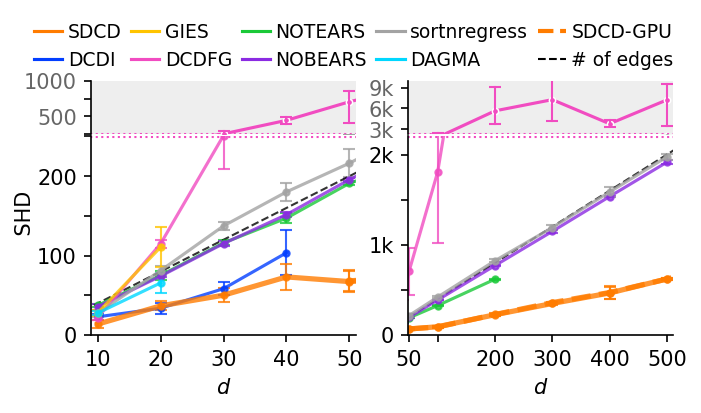

In [60]:
fig, axs = plt.subplots(
    2,
    2,
    figsize=(5, 2.2),
    dpi=150,
    gridspec_kw={"height_ratios": [0.8, 3]},
)

metric = "shd"
DEFAULT_LW = 1.5
SDCI_LW = 2.5
ERR_KW = {
    "elinewidth": 1,
    "capsize": 3,
}
HUE_ORDER = [
    "DCDI",
    "SDCI",
    "SDCI-GPU",
    "NOTEARS",
    "NOBEARS",
    "DCDFG",
    "sortnregress",
    "GIES",
    "DAGMA",
]

ALPHA = 0.8

for method_name in HUE_ORDER:
    ls = "-"
    lw = DEFAULT_LW
    if method_name == "SDCI":
        lw = SDCI_LW
    if method_name == "SDCI-GPU":
        lw = SDCI_LW
        ls = "--"

    data_filtered = observational[
        observational["Name"] == method_name
    ]
    data_groupby = data_filtered.groupby("d")[metric].agg(["mean", "std"])
    for ax in [axs[1,0], axs[1,1]]:
        ax.errorbar(
            x=data_groupby.index,
            y=data_groupby["mean"],
            yerr=data_groupby["std"],
            color=PALETTE[method_name],
            linewidth=lw,
            linestyle=ls,
            marker=".",
            **ERR_KW,
            alpha=ALPHA,
        )
    


# Plot DCDFG data separately in the upper part; hue order is for the legend
sns.lineplot(
    data=observational,
    x="d",
    y=metric,
    hue="Name",
    palette=PALETTE,
    err_style="bars",
    err_kws=ERR_KW,
    linewidth=DEFAULT_LW,
    marker=".",
    ax=axs[0, 0],
    hue_order=[
        "SDCI",
        "DCDI",
        "GIES",
        "DCDFG",
        "NOTEARS",
        "NOBEARS",
        "sortnregress",
        "DAGMA",
    ],
)
sns.lineplot(
    data=observational,
    x="d",
    y=metric,
    hue="Name",
    palette=PALETTE,
    err_style="bars",
    err_kws=ERR_KW,
    marker=".",
    linewidth=DEFAULT_LW,
    ax=axs[0, 1],
    legend=None,
    hue_order=PALETTE,
)

for ax in axs[0]:
    ax.set_facecolor("#eeeeee")


# do the cut
axs[1, 0].set_ylim(0, 250)
axs[0, 0].set_ylim(255, 900)
axs[1, 0].set_yticks([0, 50, 100, 150, 200, 250])
axs[1, 0].set_yticklabels([0, "", 100, "", 200, ""])
axs[0, 0].set_yticks([250, 500, 750, 1000])
axs[0, 0].set_yticklabels(["", "500", "", "1000"], c="#666666")

axs[1, 1].set_ylim(0, 2200)
axs[0, 1].set_ylim(2300, 10000)
axs[1, 1].set_yticks([0, 500, 1000, 1500, 2000])
axs[1, 1].set_yticklabels([0, "", "1k", "", "2k"])
axs[0, 1].set_yticks([3000, 6000, 9000])
axs[0, 1].set_yticklabels(["3k", "6k", "9k"], c="#666666")

axs[1, 0].hlines(y=249, xmin=0, xmax=1000, color=PALETTE["DCDFG"], ls=":", lw=1)
axs[0, 0].hlines(y=256, xmin=0, xmax=1000, color=PALETTE["DCDFG"], ls=":", lw=1)

axs[1, 1].hlines(y=2190, xmin=0, xmax=1000, color=PALETTE["DCDFG"], ls=":", lw=1)
axs[0, 1].hlines(y=2310, xmin=0, xmax=1100, color=PALETTE["DCDFG"], ls=":", lw=1)

#########

for j in [0, 1]:
    axs[0, j].set_xlabel("")
    axs[1, j].set_xlabel("")
    axs[0, j].set_xticks([])
    axs[1, j].set_xticks([10, 20, 30, 40, 50, 100, 200, 300, 400, 500])
    axs[1, j].set_xticklabels([10, 20, 30, 40, 50, "", 200, 300, 400, 500])

    axs[1, j].plot([0, 1000], [4 * 0, 4 * 1000], ls="--", c="black", alpha=0.8, lw=1)


axs[1, 0].set_xlim(9, 51)
axs[0, 0].set_xlim(9, 51)

axs[1, 1].set_xlim(49, 510)
axs[0, 1].set_xlim(49, 510)

axs[0, 0].spines["top"].set_visible(False)
axs[0, 0].spines["right"].set_visible(False)
axs[0, 0].spines["bottom"].set_visible(False)
axs[1, 0].spines["top"].set_visible(False)
axs[1, 0].spines["right"].set_visible(False)

axs[0, 1].spines["top"].set_visible(False)
axs[0, 1].spines["right"].set_visible(False)
axs[0, 1].spines["bottom"].set_visible(False)
axs[1, 1].spines["top"].set_visible(False)
axs[1, 1].spines["right"].set_visible(False)
# axs[1,0].spines['bottom'].set_visible(False)

axs[0, 0].set_ylabel("")
axs[0, 1].set_ylabel("")
axs[1, 1].set_ylabel("")
axs[1, 0].set_ylabel("       SHD", labelpad=1)


axs[0, 0].plot([-1], [-1], lw=2, ls="--", label="SDCD-GPU", c=PALETTE["SDCI-GPU"])
axs[0, 0].plot([-1], [-1], lw=1, ls="--", label="# of edges", c="black")

legend = axs[0, 0].legend(
    ncol=5,
    fontsize=9,
    loc="upper left",
    bbox_to_anchor=(-0.28, 2.43),  # left, top
    columnspacing=0.5,
    handletextpad=0.3,
    handlelength=1.5,
    #     bbox_to_anchor=(0, 1.3),
)
legend.get_frame().set_visible(False)
legend.get_texts()[0].set_text("SDCD")

plt.subplots_adjust(
    hspace=0.02,
    wspace=0.2,
)

axs[1, 0].set_xlabel("$d$")
axs[1, 1].set_xlabel("$d$")
plt.savefig("observational-shd.pdf", bbox_inches="tight", pad_inches=0, bbox_extra_artists=[legend])
plt.show()

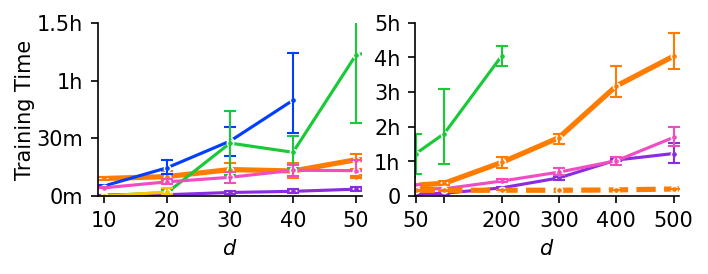

In [12]:
fig, axs = plt.subplots(
    1,
    2,
    figsize=(5, 1.5),
    dpi=150,
    gridspec_kw={"height_ratios": [1], "width_ratios": [1, 1]},
    squeeze=False,
)
metric = "train_time"
for i in range(3):
    ls = "-"
    lw = DEFAULT_LW
    if i == 1:
        observational_filtered = observational[
            ~observational["Name"].isin(["SDCI", "SDCI-GPU"])
        ]
    elif i == 0:
        observational_filtered = observational[(observational["Name"] == "SDCI")]
        lw = SDCI_LW
    elif i == 2:
        observational_filtered = observational[(observational["Name"] == "SDCI-GPU")]
        lw = SDCI_LW
        ls = "--"

    observational_filtered = observational_filtered.copy()
    observational_filtered["train_time"] /= 60

    observational_filtered = observational_filtered[
        observational_filtered["Name"].isin(PALETTE)
    ]

    sns.lineplot(
        data=observational_filtered,
        x="d",
        y=metric,
        hue="Name",
        palette=PALETTE,
        linewidth=lw,
        ls=ls,
        err_style="bars",
        err_kws=ERR_KW,
        marker=".",
        ax=axs[0, 0],
        legend=None,
        hue_order=[
            "SDCI",
            "SDCI-GPU",
            "DCDI",
            "NOTEARS",
            "NOBEARS",
            "DCDFG",
            "GIES",
            "DAGMA",
        ],
    )
    sns.lineplot(
        data=observational_filtered,
        x="d",
        y=metric,
        hue="Name",
        palette=PALETTE,
        linewidth=lw,
        ls=ls,
        err_style="bars",
        err_kws=ERR_KW,
        marker=".",
        ax=axs[0, 1],
        legend=None,
        hue_order=[
            "SDCI",
            "SDCI-GPU",
            "DCDI",
            "NOTEARS",
            "NOBEARS",
            "DCDFG",
            "GIES",
            "DAGMA",
        ],
    )
for j in [0, 1]:
    axs[0, j].set_xlabel("")
    axs[0, j].set_xlabel("$d$")
    axs[0, j].set_xticks([])
    axs[0, j].set_xticks([10, 20, 30, 40, 50, 100, 200, 300, 400, 500])
    axs[0, j].set_xticklabels([10, 20, 30, 40, 50, "", 200, 300, 400, 500])


axs[0, 0].set_xlim(9, 51)
axs[0, 1].set_xlim(49, 510)

axs[0, 0].set_ylim(0, 90)
axs[0, 0].set_yticks([0, 30, 60, 90])
axs[0, 0].set_yticklabels(["0m", "30m", "1h", "1.5h"])
axs[0, 1].set_ylim(0, 300)
axs[0, 1].set_yticks([0, 60, 120, 180, 240, 300])
axs[0, 1].set_yticklabels(["0", "1h", "2h", "3h", "4h", "5h"])

axs[0, 0].spines["top"].set_visible(False)
axs[0, 0].spines["right"].set_visible(False)
axs[0, 1].spines["top"].set_visible(False)
axs[0, 1].spines["right"].set_visible(False)


axs[0, 0].set_ylabel("Training Time", labelpad=0.8)
axs[0, 1].set_ylabel("")

plt.savefig("observational-time.pdf", bbox_inches="tight", pad_inches=0, )
plt.show()

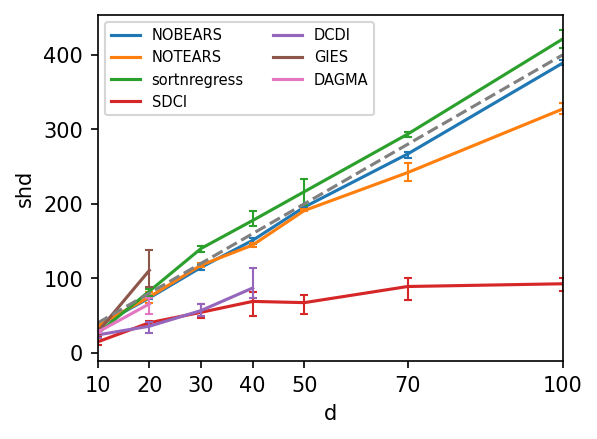